Given a genomic region (union of continous DNA portions) segmented into short DNA words, we build a statistics taking into account the frequency of occurrence of each word and the frequency of co-occurrence of pairs of words in the same window (this can be the fragment or a larger bin in the genome). We can keep the information about the linear location of the fragments or not (the best strategy can be chosen afterwards depending on the result of clustering, for example). 

In [1]:
import sys
import csv
import numpy as np
import pandas as pd
import os.path
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gensim, logging
from os import listdir
from os.path import isfile, join

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
###############################################################                                                                                                                                             
import sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

Given a bam file, we select the 50bp left/right extension of the reference locations (reference genome is GRCh37). We tokenize these fragments and build a document-term matrix from the segmented chr 1 to 22 (no X, Y and MT). This matrix is extremely sparse given tha large size of the vocabulary and the small number of terms per document.

In [2]:
vectorizer = CountVectorizer(min_df=1) # set the min numb of times a word can occur
corpus = open('/home/garner1/Work/dataset/refgenomeLP/docs/1.doc')
dtm = vectorizer.fit_transform(corpus) # get document-term matrix                                                                                                                                           
vocab = vectorizer.get_feature_names() # a list  

Get the occurrence of each unique word in the list of documents, and observe how the majority of the words is rare and there are few words shared by the majority of the documents. 

(1332933, 617422)
(1, 617422)


Text(0.5,0,u'x = number of documents sharing a given unique word')

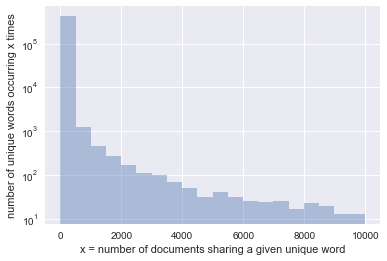

In [4]:
print (dtm.shape)
dtm_word = dtm.sum(axis=0)
print (dtm_word.shape)

%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

ax = sns.distplot(dtm_word[(dtm_word<10000) & (dtm_word>1)], bins=20, kde=False)
ax.set_yscale('log')
ax.set_ylabel('number of unique words occurring x times')
ax.set_xlabel('x = number of documents sharing a given unique word')

Decompose the document-term matrix using truncated SVD (note that singular values are sorted in ascending order). This identifies main "topics" (each one an ensemble of words of different weights, as expressed by vt rows), and the relevance of each topic for the list of documents is given by u columns:

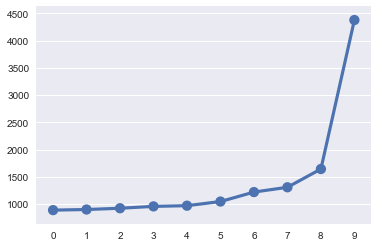

In [5]:
from scipy.sparse.linalg import svds, eigs

u, s, vt = svds(dtm.asfptype(), k=10)
import seaborn as sns
sns.set(color_codes=True)
sns.pointplot(range(len(s)),s)

In [6]:
vt.shape

(10, 617422)

In [8]:
from bokeh.plotting import figure, output_file, show

# prepare some data
mode = 8
#x = range(len(u[:,vec]))
#y = u[:,vec]
x = range(len(vt[mode,:]))
y = vt[mode,:]

# output to static HTML file
output_file("lines.html")

# create a new plot with a title and axis labels
p = figure(title="eigenword", x_axis_label='document', y_axis_label='y')

# add a line renderer with legend and line thickness
p.circle(x, y, legend="Temp.", size=6)

# show the results
show(p)

2018-05-16 11:20:16,221 : INFO : Session output file 'lines.html' already exists, will be overwritten.


A term-term co-occurence matrix is obtained as the product of dtm.T * dtm. This also is a sparse matrix and, after truncated SVD, we can identify main eigenwords:

In [10]:
wwm = dtm.transpose().dot(dtm)      # build word-word matrix

Define a new sparse matrix, which is the PMI, from wwm and dtm_word (the word-frequency count obtained from dtm)

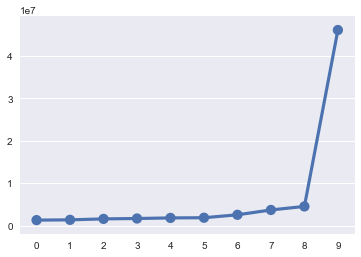

In [123]:
from scipy.sparse.linalg import svds, eigs

u, s, vt = svds(wwm.asfptype(), k=10)
import seaborn as sns
sns.set(color_codes=True)
sns.pointplot(range(len(s)),s)

In [126]:
from bokeh.plotting import figure, output_file, show

# prepare some data
mode = 8
#x = range(len(u[:,vec]))
#y = u[:,vec]
x = range(len(vt[mode,:]))
y = vt[mode,:]

# output to static HTML file
output_file("lines.html")

# create a new plot with a title and axis labels
p = figure(title="eigenword", x_axis_label='word', y_axis_label='y')

# add a line renderer with legend and line thickness
p.circle(x, y, legend="Eigenword from co-occurrence matrix", size=3)

# show the results
show(p)

2018-05-04 17:32:14,451 : INFO : Session output file 'lines.html' already exists, will be overwritten.
